In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rstl import STL
from scipy.stats import t
import math

In [2]:
root = '../data/ydata-labeled-time-series-anomalies-v1_0/'

In [3]:
real1 = pd.read_csv(root + 'A1Benchmark/real_1.csv')
is_anomaly = real1[real1['is_anomaly']==1]

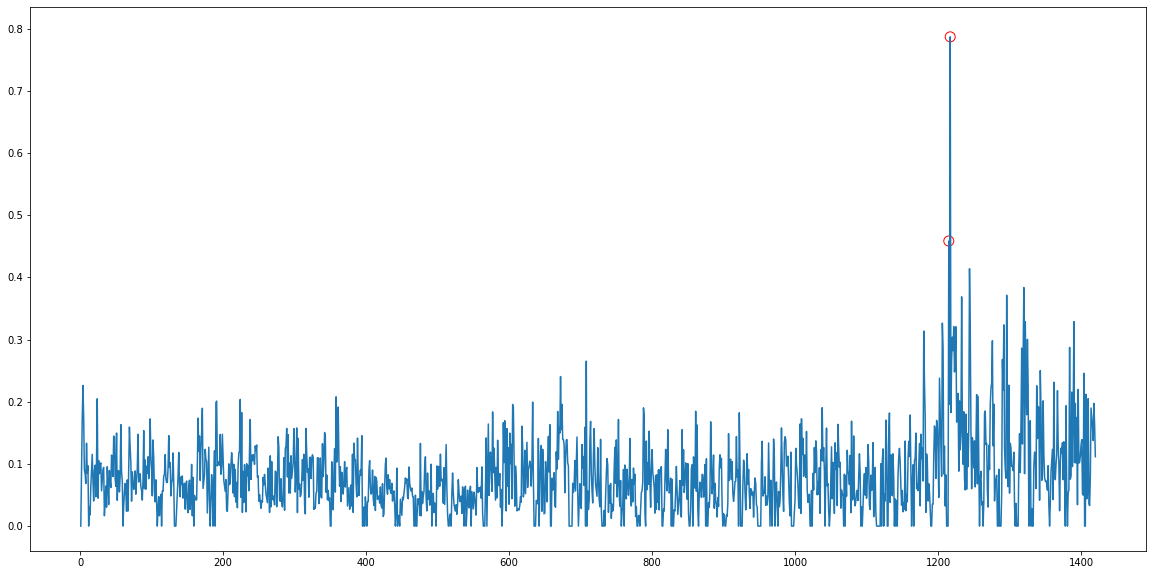

In [4]:
plt.figure(figsize=(20,10))
plt.plot(real1['timestamp'],real1['value'])
plt.scatter(is_anomaly['timestamp'],is_anomaly['value'],marker='o',c='',edgecolors='r',s=100)

- import pandas as pd
- import numpy as np
- import matplotlib.pyplot as plt
- from rstl import STL
- from scipy.stats import t
- import math

In [117]:
def AnomalyDetectionVec(x, max_anoms=0.10, direction='pos', 
                               alpha=0.05, period=None, only_last=False, 
                               threshold=None, e_value=False, longterm_period=None, 
                               plot=False, y_log=False, xlabel='', ylabel='count', 
                               title=None, verbose=False):
    #Arg:
    # x: Time series as a column data frame, list, or vector, where the column consists of the observations.
    # max_anoms: Maximum number of anomalies that S-H-ESD will detect as a percentage of the data.
    # direction: Directionality of the anomalies to be detected. Options are: 'pos', 'neg', 'both'
    # alpha: The level of statistical significance with which to accept or reject anomalies.
    # period: Defines the number of observations in a single period (one week), and used during seasonal decomposition.
    # only_last: Find and report anomalies only within the last period in the time series.
    # threshold: Only report positive going anoms above the threshold specified. Options are: 'None', 'med_max', 'p95', 'p99'.
    # e_value: Add an additional column to the anoms output containing the expected value.
    # longterm_period: Defines the number of observations for which the trend can be considered 
        # flat. The value should be an integer multiple of the number of observations in a single period. 
        # This increases anom detection efficacy for time series that are greater than a month.
    # plot: A flag indicating if a plot with both the time series and the estimated anoms, indicated by circles, should also be returned.
    # y_log: Apply log scaling to the y-axis. This helps with viewing plots that have extremely large positive anomalies relative to the rest of the data.
    # xlabel: X-axis label to be added to the output plot.
    # ylabel: Y-axis label to be added to the output plot.
    # return: dict with key 'anoms'
    import warnings
    
    # Check for supported inputs types and add timestamps
    if type(x) == pd.DataFrame and x.shape[1] == 1:
        df = pd.DataFrame({'timestamp':list(range(x.shape[0])), 'value':x.iloc[:,1]})
    elif type(x) ==  pd.Series:
        df = pd.DataFrame({'timestamp':list(range(len(x))), 'value':x})
    elif type(x) == list:
        df = pd.DataFrame({'timestamp':list(range(x.shape[0])), 'value':x})
    else:
        raise ValueError('x must be a single pandas dataframe, pandas series, or list.')
        
    if not all(np.isreal(list(df['value']))):
        raise ValueError('x must hold numeric values.')
        
    # Sanity check all input parameterss
    if max_anoms > 0.49:
        raise ValueError("max_anoms must be less than 50% of the data points.")
        
    if direction not in ['pos','neg','both']:
        raise ValueError("direction options are: pos | neg | both.")
        
    if not (0.01 <= alpha <= 0.1):
        warnings.warn("Warning: alpha is the statistical signifigance, and is usually between 0.01 and 0.1.")
    
    if not period:
        raise ValueError("Period must be set to the number of data points in a single period.")
        
    if only_last not in [True, False]:
        raise ValueError("only_last must be either TRUE (T) or FALSE (F).")
        
    if threshold not in [None, 'med_max', 'p95', 'p99']:
        raise ValueError("threshold options are: None | med_max | p95 | p99.")
  
    if e_value not in [True, False]:
        raise ValueError("e_value must be either TRUE (T) or FALSE (F)")
        
    if plot not in [True, False]:
        raise ValueError("plot must be either TRUE (T) or FALSE (F)")
    
    if y_log not in [True, False]:
        raise ValueError("y_log must be either TRUE (T) or FALSE (F)")

    if type(xlabel) is not str:
        raise ValueError("xlabel must be a string")
    
    if type(ylabel) is not str:
        raise ValueError("ylabel must be a string")
    
    if type(title) is not str and title is not None:
        raise ValueError("title must be a string")
    
    if not title:
        title = ""
    else:
        title = title + ":"
        
    # -- Main analysis: Perform S-H-ESD
    num_obs  = df.shape[0]
    
    if max_anoms < 1/num_obs:
        max_anoms = 1/num_obs
    
    # -- Setup for longterm time series
    
    # If longterm is enabled, break the data into subset data frames and store in all_data,
    if longterm_period:
        all_data = []
        # Subset x into two week chunks
        for i in range(0,num_obs,longterm_period):
            start_index = i
            end_index = min((start_index + longterm_period), num_obs)
            if end_index - start_index == longterm_period:
                all_data.append(df.iloc[start_index:end_index])
            else:
                all_data.append(df.iloc[num_obs - longterm_period:num_obs])
    else:
        all_data = [df]
    
    # Create empty data frames to store all anoms and seasonal+trend component from decomposition
    all_anoms  = pd.DataFrame({'timestamp':[],'value':[]})
    seasonal_plus_trend = pd.DataFrame({'timestamp':[],'value':[]})
    
    # Detect anomalies on all data (either entire data in one-pass, or in 2 week blocks if longterm=TRUE)
    for i in range(len(all_data)):
        if direction == 'pos':
            one_tail = True
            upper_tail = True
        elif direction == 'neg':
            one_tail = True
            upper_tail = False
        else:
            one_tail = False
            upper_tail = True
        # detect_anoms actually performs the anomaly detection and returns the results in a list containing the anomalies
        # as well as the decomposed components of the time series for further analysis.
        s_h_esd_timestamps = detect_anoms(all_data[i], k=max_anoms, alpha=alpha, num_obs_per_period=period, use_decomp=True, use_esd=False,
                                         one_tail=one_tail, upper_tail=upper_tail, verbose=verbose)
        
        data_decomp =  s_h_esd_timestamps['stl']
        s_h_esd_timestamps  = s_h_esd_timestamps['anoms']
        
        # -- Step 3: Use detected anomaly timestamps to extract the actual anomalies (timestamp and value) from the data
        if s_h_esd_timestamps:
            anoms = all_data[i][all_data[i]['timestamp'].isin(s_h_esd_timestamps)]
        else:
            anoms  = pd.DataFrame({'timestamp':[],'value':[]})
            
        # Filter the anomalies using one of the thresholding functions if applicable
        if threshold:
            # Calculate daily max values
            if longterm_period:
                group = [x//period for x in range(longterm_period)]
            else:
                group = [x//period for x in range(num_obs)]
            periodic_maxs = all_data[i]['value'].groupby(group).aggregate(max)
            
            # Calculate the threshold set by the user
            if threshold == 'med_max':
                thresh = np.median(periodic_maxs)
            elif threshold == 'p95':
                thresh = np.quantile(periodic_maxs,0.95)
            elif threshold == 'p99':
                thresh = np.quantile(periodic_maxs,0.99)
            
            # Remove any anoms below the threshold
            anoms  = anoms[anoms['value']>=thresh]
        
        all_anoms = all_anoms.append(anoms)
        seasonal_plus_trend = seasonal_plus_trend.append(data_decomp)
    
    # Cleanup potential duplicates
    all_anoms.drop_duplicates(['timestamp'],inplace=True) 
    seasonal_plus_trend.drop_duplicates(['timestamp'],inplace=True)
    
    # If only_last was set by the user, create subset of the data that represent the most recent period
    if only_last:
        x_subset_single_period = df.iloc[-period:]
        # Let's try and show 7 periods prior
        past_obs = period * 7
        if num_obs < past_obs:
            past_obs = num_obs-period
        
        # When plotting anoms for the last period only we only show the previous 7 periods of data
        x_subset_previous = df.iloc[-past_obs:-period]
        all_anoms = all_anoms[all_anoms['timestamp']>=x_subset_single_period['timestamp'][0]]
        num_obs = len(x_subset_single_period)
    
    # Calculate number of anomalies as a percentage
    anom_pct = (len(all_anoms) / num_obs) * 100
    
    # If there are no anoms, then let's exit
    if anom_pct == 0:
        if verbose:
            print('No anomalies detected.')
        return {'anoms':None,'plt':None}
        
    # Store expected values if set by user
    anoms = all_anoms
    if e_value:
        anoms = pd.DataFrame({'timestamp':anoms['timestamp'],
                              'value':anoms['value'],
                              'expected_value':seasonal_plus_trend[seasonal_plus_trend['timestamp'].isin(all_anoms['timestamp'])['value']]})
    
    if plot:
        # -- Build title for plots utilizing parameters set by user
        plot_title = title + str(round(anom_pct,2)) + '% Anomalies (alpha=' + str(alpha) + ', direction=' + direction + ')'
        if not longterm_period:
            plot_title = plot_title + ', longterm=T'
        
        plt.figure(figsize=(20,10))
        plt.plot(df['timestamp'],df['value'])
        plt.scatter(anoms['timestamp'],anoms['value'],marker='o',c='',edgecolors='r',s=100)
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.title(plot_title)    
        return {'anoms':anoms,'plt':plt.show()}
    else:
        return {'anoms':anoms,'plt':None}

In [118]:
def detect_anoms(data, k = 0.49, alpha = 0.05, num_obs_per_period = None,
                         use_decomp = True, use_esd = False, one_tail = True,
                         upper_tail = True, verbose = False):
     # Detects anomalies in a time series using S-H-ESD.
     #
     # Args:
     # data: Time series to perform anomaly detection on.
     # k: Maximum number of anomalies that S-H-ESD will detect as a percentage of the data.
     # alpha: The level of statistical significance with which to accept or reject anomalies.
     # num_obs_per_period: Defines the number of observations in a single period, and used during seasonal decomposition.
     # use_decomp: Use seasonal decomposition during anomaly detection.
     # use_esd: Uses regular ESD instead of hybrid-ESD. Note hybrid-ESD is more statistically robust.
     # one_tail: If TRUE only positive or negative going anomalies are detected depending on if upper_tail is TRUE or FALSE.
     # upper_tail: If TRUE and one_tail is also TRUE, detect only positive going (right-tailed) anomalies. If FALSE and one_tail is TRUE, only detect negative (left-tailed) anomalies.
     # verbose: Additionally printing for debugging.
     # Returns:
     # A list containing the anomalies (anoms) and decomposition components (stl).
    
    if not num_obs_per_period:
        raise ValueError('must supply period length for time series decomposition')
    
    # Check to make sure we have at least two periods worth of data for anomaly context
    num_obs = data.shape[0]
    if num_obs < num_obs_per_period*2:
        raise ValueError('Anom detection needs at least 2 periods worth of data')
        
    # Check if our timestamps are posix
    posix_timestamp = False
    
    # Check NAs
    if data['value'].isnull().any():
        raise ValueError('Data contains non-leading NAs. We suggest replacing NAs with interpolated values')
    
    # -- Step 1: Decompose data. This returns a univarite remainder which will be used for anomaly detection. Optionally, we might NOT decompose.
    data_decomp = STL(data['value'],freq=num_obs_per_period,s_window="periodic",robust=True)
    
    # Remove the seasonal component, and the median of the data to create the univariate remainder
    data_remove_seasonal = pd.DataFrame({'timestamp':list(range(num_obs)), 'value':list(data['value'] - data_decomp.trend - np.median(data['value']))})
    
    # Store the smoothed seasonal component, plus the trend component for use in determining the "expected values" option
    data_seasonal_trend = pd.DataFrame({'timestamp':list(range(num_obs)), 'value':list(data_decomp.trend+data_decomp.seasonal)})
    
    max_outliers = int(num_obs*k)
    if max_outliers == 0:
        raise ValueError('With longterm=True, AnomalyDetection splits the data into 2 week periods by default. You have %d observations in a period, which is too few. Set a higher piecewise_median_period_weeks.'%num_obs)
    
    
    # Define values and vectors.
    n = num_obs
    R_idx = list(range(max_outliers))
    num_anoms = -1
    
    # Compute test statistic until r=max_outliers values have been removed from the sample.
    for i in range(max_outliers):
        if verbose:
            print(str(i+1)+'/'+str(max_outliers)+' completed')
            
        if one_tail:
            if upper_tail:
                ares = data_remove_seasonal['value'] - np.median(data_remove_seasonal['value'])
            else:
                ares = np.median(data_remove_seasonal['value']) - data_remove_seasonal['value']
        else:
            ares = abs(data_remove_seasonal['value'] - np.median(data_remove_seasonal['value']))
        
        # protect against constant time series
        data_sigma = data_remove_seasonal['value'].mad()
        if data_sigma == 0:
            break
            
        ares = ares/data_sigma
        R = max(ares)
        
        temp_max_idx = np.where(ares==R)[0][0]
        
        R_idx[i] = temp_max_idx
        
        data_remove_seasonal = data_remove_seasonal[data_remove_seasonal['timestamp']!=temp_max_idx]
        
        ## Compute critical value.
        if one_tail:
            p = 1 - alpha/(n-i)
        else:
            p = 1 - alpha/(2*(n-i))
            
        qt = t.ppf(p, (n - i - 2))
        lam = qt*(n-i-1) / math.sqrt((n-i-2+qt**2)*(n-i))
        
        if R > lam:
            num_anoms = i + 1
            
    if num_anoms >= 0:
        R_idx = R_idx[0:num_anoms]
    else:
        R_idx = None
        
    return({'anoms':R_idx, 'stl':data_seasonal_trend})

1/2 completed
2/2 completed


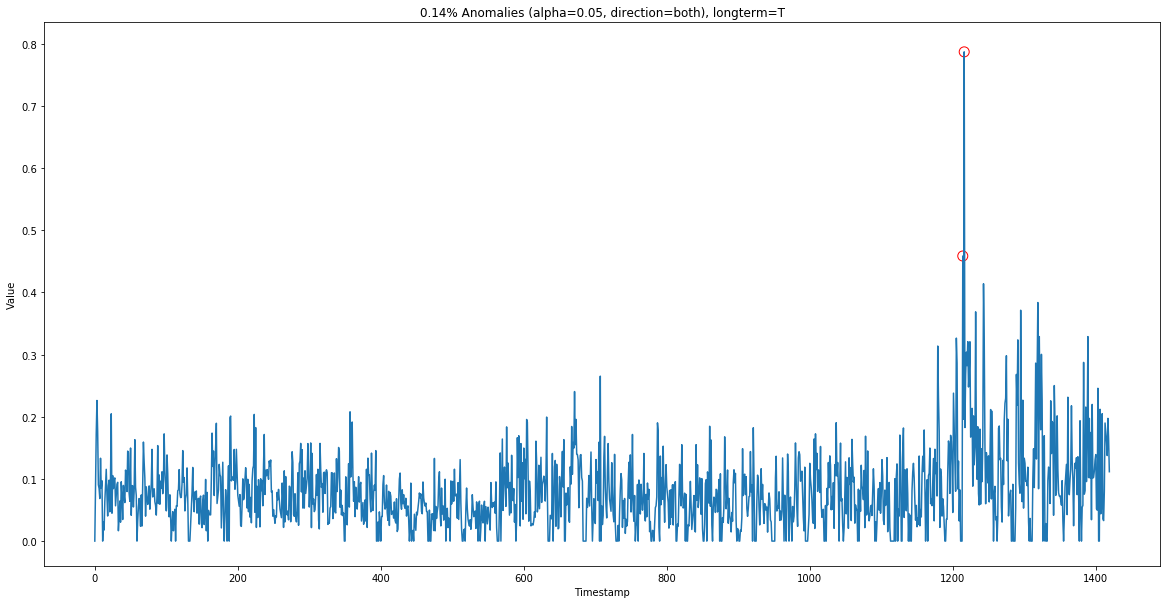

{'anoms':       timestamp     value
 1214     1214.0  0.458686
 1216     1216.0  0.787127, 'plt': None}

In [119]:
AnomalyDetectionVec(real1['value'],max_anoms=0.0015,period=24,direction='both',verbose=True,plot=True)